##### Youtube Video: https://www.youtube.com/watch?v=lOVZye9NEfI&t

## Importing Libararies

In [3]:
import numpy as np
import math
import pandas as pd
from datetime import datetime, timedelta, date
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Truck Types

#### Trip_cost = A*x^(1-n)

##### A,n - Constant for Truck Type; 
##### x - Trip Distance

In [4]:
# [Truck Name, Truck capacity in Tonns, A , n]

Truck_list = [["A_14_Feet_truck", 3, 251.45, 0.315],
              ["B_17_Feet_truck", 4, 292.94, 0.316],
              ["C_19_Feet_truck", 7, 382.15, 0.343],
              ["D_22_Feet_truck", 15, 668.39, 0.38]]

#Sorting truck in decending order of capacity for easy allocation logic

sorter_guide = []
max_truck_capacity = 0
for i in range(len(Truck_list)):
    sorter_guide.append([i,int(Truck_list[i][1])])
    if int(Truck_list[i][1])>=max_truck_capacity:
        max_truck_capacity = int(Truck_list[i][1])
sorter_guide = np.array(sorter_guide)
sorter_guide = sorter_guide[sorter_guide[:,1].argsort()[::-1]]
sorter_temp = []
for i in range(len(sorter_guide)):
    sorter_temp.append(Truck_list[sorter_guide[i][0]])
Truck_list = np.array(sorter_temp)   

print('\n',"max_truck_capacity =",max_truck_capacity,'\n')
Truck_list


 max_truck_capacity = 15 



array([['D_22_Feet_truck', '15', '668.39', '0.38'],
       ['C_19_Feet_truck', '7', '382.15', '0.343'],
       ['B_17_Feet_truck', '4', '292.94', '0.316'],
       ['A_14_Feet_truck', '3', '251.45', '0.315']], dtype='<U32')

## Distance Calculator code

In [5]:
from math import sin, cos, sqrt, atan2, radians

def Distance_calculator(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #print("Result:", distance)
    #print("Should be:", 278.546, "km")
    
    return distance

## Clark Wright Savings Algorithm

In [6]:
def CW_truck_assignment(locations_list,weights_list,vr_status):
    
    #distance_matrix = [[101.2*(abs(locations_list[i][0]-locations_list[j][0])+abs(locations_list[i][1]-locations_list[j][1])) for i in range(len(locations_list))] for j in range(len(locations_list))]
    distance_matrix = [[Distance_calculator(locations_list[i][0],locations_list[i][1],locations_list[j][0],locations_list[i][1]) for i in range(len(locations_list))] for j in range(len(locations_list))]
    distance_matrix = np.array(distance_matrix)
    #print(distance_matrix)

    cw_savings_matrix = [[(distance_matrix[0][i+1]+distance_matrix[0][j+1]-min(distance_matrix[0][i+1],distance_matrix[0][j+1])-distance_matrix[i+1][j+1]) for i in range(len(locations_list)-1)] for j in range(len(locations_list)-1)]
    if vr_status == True:
        savings_threshold = 0.42
    else:
        savings_threshold = 0.5

    cw_savings_percent_matrix = [[((distance_matrix[0][i+1]+distance_matrix[0][j+1]-min(distance_matrix[0][i+1],distance_matrix[0][j+1])-distance_matrix[i+1][j+1])/(distance_matrix[0][i+1]+distance_matrix[0][j+1])) for i in range(len(locations_list)-1)] for j in range(len(locations_list)-1)]
    
    cw_savings_matrix = np.array(cw_savings_matrix)
    for i in range(len(cw_savings_matrix)):
        cw_savings_matrix[i][i]=0
    #print(cw_savings_matrix)
    for i in range(len(cw_savings_percent_matrix)):
        cw_savings_percent_matrix[i][i]=0
    #print(cw_savings_matrix)

    cw_savings_list=[]

    for i in range(len(cw_savings_matrix)):
        j=0
        while j<i:
            if cw_savings_percent_matrix[i][j]>=savings_threshold:
                cw_savings_list.append([i+1,j+1,cw_savings_matrix[i][j]])
            j=j+1
    cw_savings_list=np.array(cw_savings_list)
    
    if(len(cw_savings_list)>0):
        cw_savings_list=cw_savings_list[cw_savings_list[:,2].argsort()[::-1]]
    #print(cw_savings_list)

    truck_assignment_cw_savings = []

    for i in range(len(cw_savings_list)):
        truck_assignment_cw_savings.append([cw_savings_list[i][0],cw_savings_list[i][1],cw_savings_list[i][2],0,0,0])

    truck_assignment_cw_savings = np.array(truck_assignment_cw_savings)
    #print('\n',truck_assignment_cw_savings)

    truck_assignment_matrix = np.zeros((len(weights_list), len(weights_list)))
    truck_assigned_weights = np.zeros((len(weights_list)))
    truck_assigned_savings = np.zeros((len(weights_list)))

    #print('\n',truck_assignment_matrix)

    truck_count=0

    for i in range(len(truck_assignment_cw_savings)):
        #print(i)
        loc1 = int(truck_assignment_cw_savings[i][0])
        loc2 = int(truck_assignment_cw_savings[i][1])
        truck_no =0

        if truck_assignment_cw_savings[i][3]==0 and truck_assignment_cw_savings[i][4]==0:
            #print(i+1," both")
            if weights_list[int(loc1-1)]+weights_list[int(loc2-1)]<=max_truck_capacity:
                truck_no = truck_count
                truck_count = truck_count+1
                truck_assignment_matrix[int(loc1-1)][int(truck_no)]=1
                truck_assignment_matrix[int(loc2-1)][int(truck_no)]=1
                #truck_assigned_weights[int(truck_no)]=weights_list[int(loc1-1)]+weights_list[int(loc2-1)]
                truck_assignment_cw_savings[i][3]=1
                truck_assignment_cw_savings[i][4]=1
                truck_assignment_cw_savings[i][5]=truck_no+1
                truck_assigned_savings[int(truck_no)] = truck_assigned_savings[int(truck_no)]+truck_assignment_cw_savings[i][2]

                for j in range(len(truck_assignment_cw_savings)):
                    if truck_assignment_cw_savings[j][0]==loc1 or truck_assignment_cw_savings[j][1]==loc1:
                        if truck_assignment_cw_savings[j][0]==loc1:
                            truck_assignment_cw_savings[j][3]=1
                            truck_assignment_cw_savings[j][5]=truck_no+1
                        else:
                            truck_assignment_cw_savings[j][4]=1
                            truck_assignment_cw_savings[j][5]=truck_no+1

                    if truck_assignment_cw_savings[j][0]==loc2 or truck_assignment_cw_savings[j][1]==loc2:
                        if truck_assignment_cw_savings[j][0]==loc2:
                            truck_assignment_cw_savings[j][3]=1
                            truck_assignment_cw_savings[j][5]=truck_no+1
                        else:
                            truck_assignment_cw_savings[j][4]=1
                            truck_assignment_cw_savings[j][5]=truck_no+1

        elif truck_assignment_cw_savings[i][3]==1 and truck_assignment_cw_savings[i][4]==1:
            null=0
        elif truck_assignment_cw_savings[i][3]+truck_assignment_cw_savings[i][4]==1:
            #print(i+1," only1")
            #print('\n',truck_assignment_cw_savings,'\n')
            truck_no = truck_assignment_cw_savings[i][5]-1

            if truck_assignment_cw_savings[i][3]==0:
                loc1 = truck_assignment_cw_savings[i][0]
            else:
                loc1 = truck_assignment_cw_savings[i][1]


            if truck_assigned_weights[int(truck_no)]+weights_list[int(loc1-1)]<=max_truck_capacity:
                #print("test sucess at:",i+1)
                truck_assignment_matrix[int(loc1-1)][int(truck_no)]=1
                #truck_assigned_weights[int(truck_no)]=truck_assigned_weights[int(truck_no)]+weights_list[int(loc1-1)]
                truck_assignment_cw_savings[i][3]=1
                truck_assignment_cw_savings[i][4]=1
                truck_assigned_savings[int(truck_no)] = truck_assigned_savings[int(truck_no)]+truck_assignment_cw_savings[i][2]
                for j in range(len(truck_assignment_cw_savings)):
                    if truck_assignment_cw_savings[j][0]==loc1 or truck_assignment_cw_savings[j][1]==loc1:
                        if truck_assignment_cw_savings[j][0]==loc1:
                            truck_assignment_cw_savings[j][3]=1
                            truck_assignment_cw_savings[j][5]=truck_no+1
                        else:
                            truck_assignment_cw_savings[j][4]=1
                            truck_assignment_cw_savings[j][5]=truck_no+1

        for i in range(truck_count):
            current_wt = 0
            for j in range(len(weights_list)):
                current_wt = current_wt+truck_assignment_matrix[j][i]*weights_list[j]
            truck_assigned_weights[i]=current_wt
    
    dummy_no = 0
    for i in range(len(truck_assignment_matrix)):
        assigned = 0
        for j in range(len(weights_list)):
            assigned = assigned + truck_assignment_matrix[i][j]
        if assigned == 1:
            #print("Location no:",i+1,"has been already assigned by CW savings")
            dummy_no =+ 1
        elif assigned >1:
            #print("Location no:",i+1,"some error has occurred")
            dummy_no =+ 1
        elif assigned ==0:
            #print("Location no:",i+1,"has not been assigned yet by CW savings")
            truck_assignment_matrix[i][int(truck_count)]=1
            truck_count=truck_count+1

    for i in range(truck_count):
        current_wt = 0
        for j in range(len(weights_list)):
            current_wt = current_wt+truck_assignment_matrix[j][i]*weights_list[j]
        truck_assigned_weights[i]=current_wt


    truck_assigned_distances = np.zeros((len(weights_list)))

    for i in range(len(truck_assigned_distances)):
        for j in range(len(truck_assignment_matrix)):
            if truck_assignment_matrix[j][i]==1:
                truck_assigned_distances[i]=truck_assigned_distances[i]+distance_matrix[j+1][0]
        truck_assigned_distances[i]=truck_assigned_distances[i]-truck_assigned_savings[i]

    #print(2*'\n',np.array(distance_matrix))
    #print(2*'\n',np.array(cw_savings_matrix))  
    #print(2*'\n',np.array(cw_savings_list))

    #print('\n',"Assignment matrix:",'\n',truck_assignment_matrix,2*'\n',"Number of trucks:",truck_count,2*'\n',"Truck weight matrix:",truck_assigned_weights,2*'\n',"Truck savings:",truck_assigned_savings,2*'\n',"Truck Distances:",truck_assigned_distances)

    truck_assigned_type = np.zeros((len(weights_list)))

    for i in range(len(truck_assigned_distances)):
        for j in range(len(Truck_list)):
            if(truck_assigned_weights[i]>0 and truck_assigned_weights[i]<=int(Truck_list[j][1])):
                truck_assigned_type[i] = j+1
    
    truck_type_counter = []
    
    for p in range(len(Truck_list)):
        count = 0
        for j in range(len(truck_assigned_type)):
            if truck_assigned_type[j] == p+1:
                count = count +1
        truck_type_counter.append(count)

    truck_costs = np.zeros((len(weights_list)))

    for i in range(len(truck_costs)):
        if truck_assigned_type[i]>0 and truck_assigned_distances[i]>0:
            k=int(truck_assigned_type[i]-1)
            truck_costs[i]=round(float(truck_assigned_distances[i])*float(Truck_list[k][2])*(float(truck_assigned_distances[i])**(float(Truck_list[k][3])*-1)),1)

    #print('\n',"Truck costs:",truck_costs)
    
    #print(cw_savings_percent_matrix[0])
    return(sum(truck_costs),truck_count,truck_type_counter)

## Importing Data

In [7]:
shipmentsdata = pd.read_csv("sampledatatruckrouting1.csv")

print(shipmentsdata.describe())
shipmentsdata

           Latitude     Longitude        Weight
count  10909.000000  10909.000000  10909.000000
mean      21.433791     78.261483      7.345943
std        5.596902      4.829720      3.634435
min        8.170000     69.810000      3.200018
25%       17.975600     74.550000      5.619656
50%       22.249200     77.333300      6.273962
75%       26.472500     80.275000      6.960793
max       34.400000     93.950000     14.998702


,Date,City,Latitude,Longitude,Weight
0,19-09-2020,Delhi,28.6600,77.2300,6.226701
1,25-05-2020,Ludhiana,30.9083,75.8486,6.678444
2,11-03-2020,Bilaspur,22.1500,82.0167,6.378018
3,07-10-2020,Surat,21.1700,72.8300,6.792099
4,08-06-2020,Ahmadnagar,19.0833,74.7333,5.799108
...,...,...,...,...,...
10904,15-10-2020,Delhi,28.6600,77.2300,12.902800
10905,22-03-2020,Bangalore,12.9699,77.5980,6.258130
10906,31-07-2020,Hyderabad,17.3667,78.4667,6.742273
10907,28-09-2020,Jammu,32.7333,74.8500,6.845631


### Displaying weight Distributions

,Weight
City,
Delhi,9356.287958
Mumbai,7809.035025
Kolkata,5722.129724
Bangalore,4654.047575
Chennai,3878.579830
...,...
Handwara,53.631718
Ramgundam,52.078320
Sambalpur,48.939572


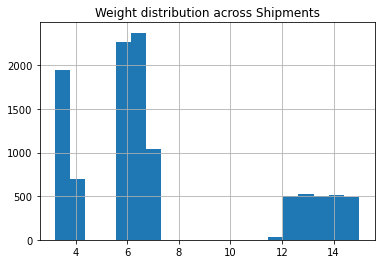

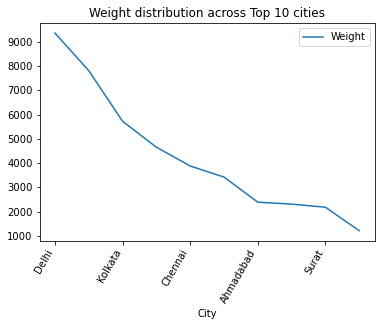

In [8]:
shipmentsdata['Weight'].hist(bins=20)
plt.title('Weight distribution across Shipments')

city_display = pd.DataFrame(shipmentsdata.groupby(['City'], as_index=False)['Weight'].sum())
city_display.set_index('City',inplace=True)

city_display = city_display.sort_values(by='Weight', ascending=False)
city_display.head(10).plot(title='Weight distribution across Top 10 cities')
plt.xticks(rotation=60, ha='right')



city_display

## Pre-Processing Dates and Input Shipment Data

In [9]:
dda = pd.DataFrame(shipmentsdata.groupby(['Date','City','Latitude','Longitude'], as_index=False)['Weight'].sum())
shipmentsdata.tail(20)

job_status = 0

for i in range(len(dda)):
    if dda['Weight'][i] > max_truck_capacity:
        remainder = dda['Weight'][i]%max_truck_capacity
        no_of_splits = int(dda['Weight'][i]/max_truck_capacity - remainder/max_truck_capacity)
        #print(dda['Weight'][i],no_of_splits,remainder)
        dda['Weight'][i] = remainder
        gg = dda[dda.index == i]
        gg['Weight'][i]= max_truck_capacity
        for j in range(no_of_splits):
            dda = dda.append(gg,ignore_index=True)

shipmentsdata_new = pd.DataFrame(dda)
shipmentsdata_new['Date'] = pd.to_datetime(shipmentsdata_new['Date'], format='%d-%m-%Y')

source_Latitude_list = np.array(shipmentsdata['Latitude'])
source_Longitude_list = np.array(shipmentsdata['Longitude'])
weights_list = np.array(shipmentsdata['Weight'])
source_dates = np.array(shipmentsdata['Date'])
#print(source_dates)

#for i in range(len(source_dates)):
#    source_dates[i] = datetime.strptime(source_dates[i],'%d-%m-%Y')
#print(source_dates)
delta = timedelta(days=1)

#print(max(source_dates))
#max(source_dates)+ delta

no_of_days = int((max(shipmentsdata_new['Date'])-min(shipmentsdata_new['Date'])).days+1)

#print(shipmentsdata_new['Date'][3]>=max(source_dates))

#len(shipmentsdata_new)

C:\Users\ALURU JEETENDRA\AppData\Local\Temp\ipykernel_9908\2551640550.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dda['Weight'][i] = remainder
C:\Users\ALURU JEETENDRA\AppData\Local\Temp\ipykernel_9908\2551640550.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['Weight'][i]= max_truck_capacity
C:\Users\ALURU JEETENDRA\AppData\Local\Temp\ipykernel_9908\2551640550.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dda = dda.append(gg,ignore_index=True)


## Hub Location and Planning Horizon

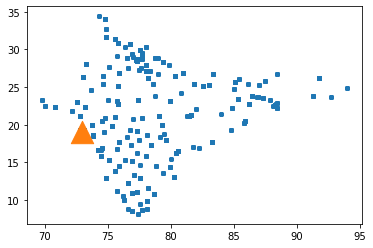

In [10]:
source_coordinates = [19,73]
planning_horizon = 1      # Enter the no. of days you want to plan together, only intergers >=1

plt.scatter(shipmentsdata_new['Longitude'],shipmentsdata_new['Latitude'] ,marker='o', s = 15)
plt.scatter(source_coordinates[1],source_coordinates[0], marker = '^', s = 500)

## Running the Simulation

___Result :- 

Estimated Cost with no Vehicle Routing: 225218191.0
Estimated Cost with Vehicle Routing: 191701021.0 

Estimated Cost Savings with Vehicle Routing: 14.9 % 

No. of Trucks with no VR: 8823
No. of Trucks with VR: 6902


C:\Users\ALURU JEETENDRA\AppData\Local\Temp\ipykernel_4288\2522269351.py:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Truck_list_table.drop(['A','n'],1)


<AxesSubplot:xlabel='Capacity in Tonne'>

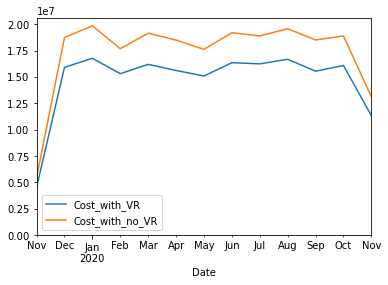

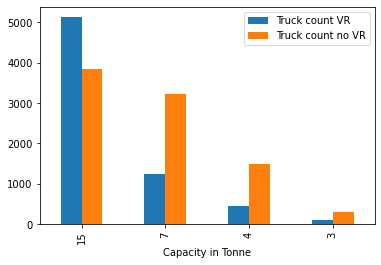

In [10]:
result_matrix = []
truck_type_total_count_VR = []
for p in range(len(Truck_list)):
    truck_type_total_count_VR.append(0)

truck_type_total_count_noVR = []
for p in range(len(Truck_list)):
    truck_type_total_count_noVR.append(0)

truck_type_total_count_VR = np.array(truck_type_total_count_VR)
truck_type_total_count_noVR = np.array(truck_type_total_count_noVR)


for j in range(0,no_of_days,planning_horizon):
    
    clear_output(wait=True)
    print("____Simulation Progress :",round(100*j/no_of_days,1),"%")
    weights_temp = []
    locations_temp = [[source_coordinates[0],source_coordinates[1]]]
    range_start = min(shipmentsdata_new['Date'])+j*delta
    range_end = min(shipmentsdata_new['Date'])+(j+planning_horizon)*delta
    
    rslt_df = shipmentsdata_new[shipmentsdata_new['Date'] >= range_start]
    rslt_df = rslt_df[rslt_df['Date'] < range_end]
    #print(rslt_df.iloc[0,'Latitude'])
    
    
    for i in range(len(rslt_df)):
        locations_temp.append([rslt_df.iloc[i]['Latitude'],rslt_df.iloc[i]['Longitude']])
        weights_temp.append(rslt_df.iloc[i]['Weight'])
    if len(locations_temp)>1:
        result_output_vr = CW_truck_assignment(locations_temp,weights_temp,True)
        result_output_no_vr = CW_truck_assignment(locations_temp,weights_temp,False)
        result_matrix.append([range_start,result_output_vr[0],result_output_no_vr[0]])
        truck_type_total_count_VR = np.add(truck_type_total_count_VR, np.array(result_output_vr[2]))
        truck_type_total_count_noVR = np.add(truck_type_total_count_noVR, np.array(result_output_no_vr[2]))
    
clear_output(wait=True)
result_matrix

df = pd.DataFrame(result_matrix, columns=['Date', 'Cost_with_VR', 'Cost_with_no_VR'])
df = df.set_index('Date')

Truck_list_table = pd.DataFrame(Truck_list, columns=['Name','Capacity in Tonne','A','n'])
Truck_list_table.drop(['A','n'],1)
Truck_list_table['Truck count VR'] = pd.Series(truck_type_total_count_VR)
Truck_list_table['Truck count no VR'] = pd.Series(truck_type_total_count_noVR)


print("___Result :-",'\n')
print("Estimated Cost with no Vehicle Routing:",round(sum(df['Cost_with_no_VR']),0))
print("Estimated Cost with Vehicle Routing:",round(sum(df['Cost_with_VR']),0),'\n')
#print('\n')
print("Estimated Cost Savings with Vehicle Routing:",round((sum(df['Cost_with_no_VR'])-sum(df['Cost_with_VR']))*100/sum(df['Cost_with_no_VR']),1),"%",'\n')
print("No. of Trucks with no VR:",sum(Truck_list_table['Truck count no VR']))
print("No. of Trucks with VR:",sum(Truck_list_table['Truck count VR']))

df.resample('M').sum().plot().axis([None, None, 0, None])
Truck_list_table.plot.bar(x='Capacity in Tonne')